# パラメータチューニング1 
## グリッドサーチver2 n_estimeter = 3000

In [2]:
import numpy as np
import pandas as pd

In [3]:
import seaborn as sns

In [4]:
from math import sqrt
import matplotlib.pyplot as plt


%matplotlib inline

In [5]:
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn import metrics
from sklearn.metrics import mean_squared_log_error,mean_squared_error
from sklearn.model_selection import KFold

import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [6]:
test_df = pd.read_csv("./input/test.csv", parse_dates=['datetime'])
train_df = pd.read_csv("./input/train.csv", parse_dates=['datetime'])

In [7]:
#datetimeの変換
import datetime as dt 
train_df['hour'] = train_df.datetime.dt.hour
train_df['weekday'] = train_df.datetime.dt.weekday
train_df['year'] = train_df.datetime.dt.year
train_df['month'] = train_df.datetime.dt.month
test_df['hour'] = test_df.datetime.dt.hour
test_df['weekday'] = test_df.datetime.dt.weekday
test_df['year'] = test_df.datetime.dt.year
test_df['month'] = test_df.datetime.dt.month

In [8]:
# 2.ベース(datetime分解あり)
train_0 = train_df.drop(columns = ['datetime', 'casual', 'registered', 'count'])
train_y = train_df['count']
test_0 = test_df.drop(columns = ['datetime'])
test_datetime = test_df['datetime']

In [9]:
# 3.countの対数関数化(小さいほうによっているときに有効)
train_y = train_df['count']
train_y_log = np.log1p(train_y + 1)
test_log = np.log(test_0+1)

In [10]:
train_y[train_y>400]

1579     452
1747     428
1771     411
1772     421
1819     537
        ... 
10855    572
10856    525
10870    678
10879    562
10880    569
Name: count, Length: 1443, dtype: int64

# countでの学習

Fold:1
RMSLE: 0.4306998111250159
-13702.389072066973
13470.620805570257


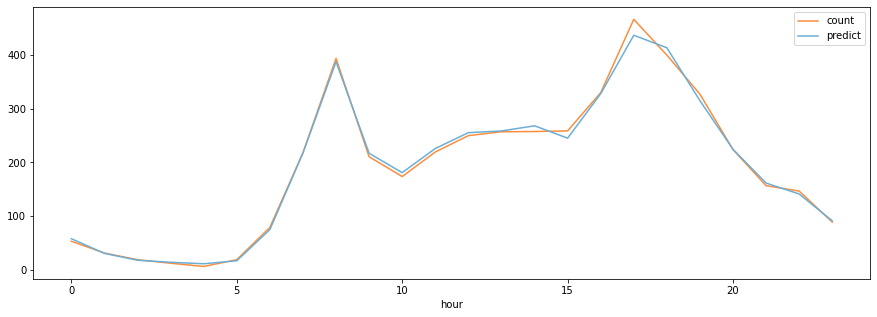

Fold:2
RMSLE: 0.4063060331556779
-13713.769966466138
12832.73565172621


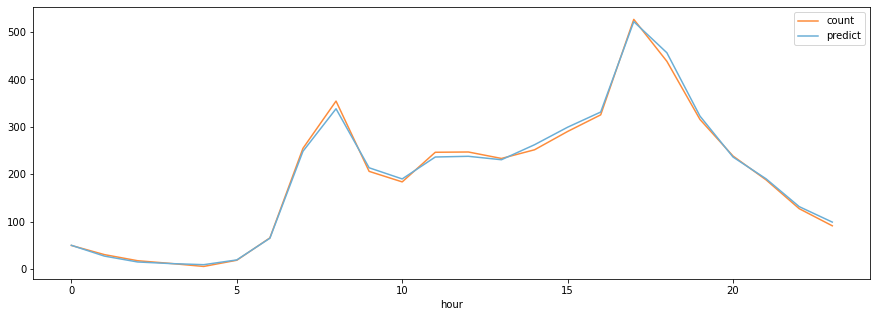

Fold:3
RMSLE: 0.4036242038185243
-11874.688190254215
13356.42519900464


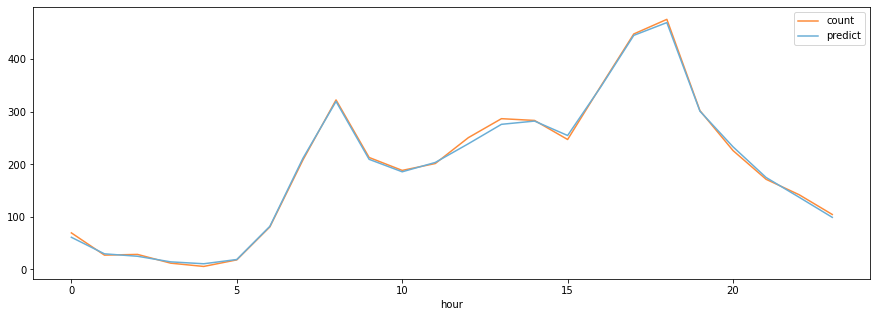

Fold:4
RMSLE: 0.43986440439587815
-13473.366961625314
14577.132301391135


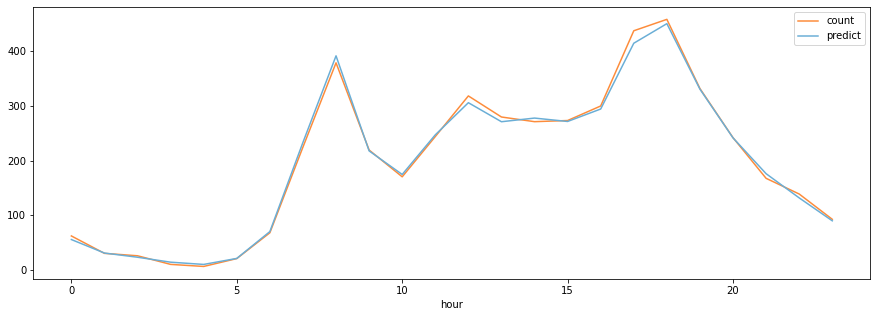

Fold:5
RMSLE: 0.43250492243401006
-13657.699862161411
13487.15637601441


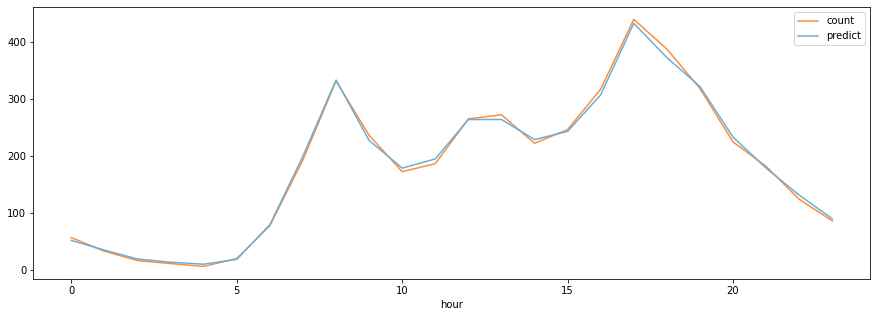

Fold:6
RMSLE: 0.39660597937586156
-14472.549163555166
12632.814377110622


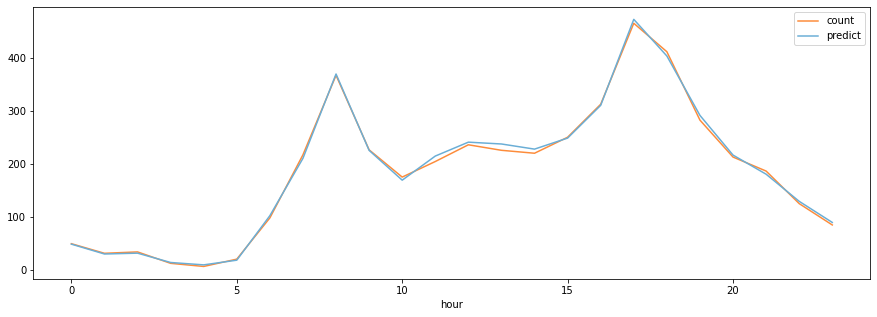

Fold:7
RMSLE: 0.39492943667261643
-13455.32778431323
13314.112122501869


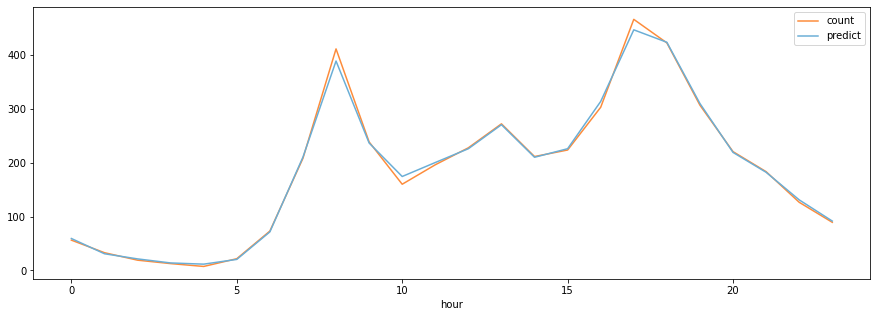

Fold:8
RMSLE: 0.4691287509687131
-12717.644361677649
13866.33074646907


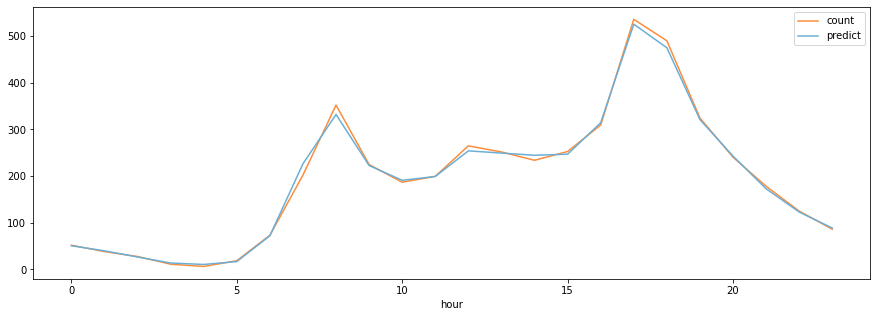

Fold:9
RMSLE: 0.41847325082695525
-14524.754539532378
12923.213451224863


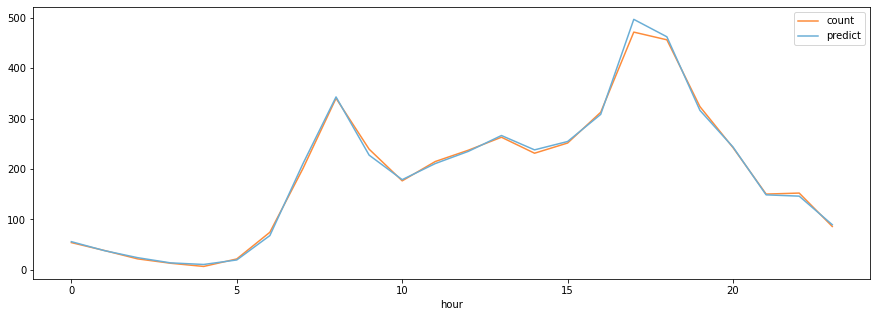

Fold:10
RMSLE: 0.41717333614973207
-12999.053723367826
12062.6247278177


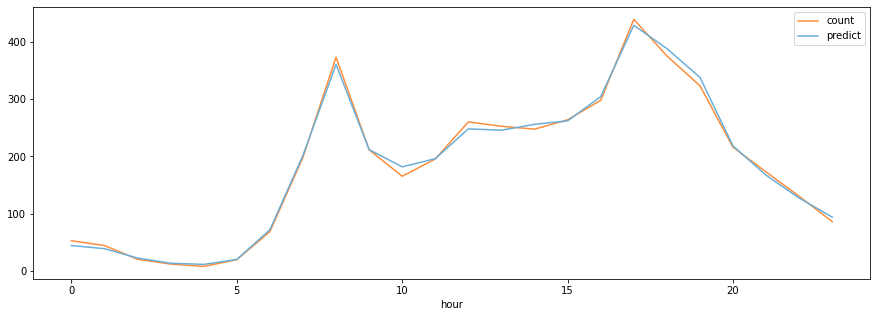

In [64]:
#デフォルト
#%%time
#scikit-learn API

kf = KFold(n_splits=10, shuffle=True, random_state=1).split(train_0, train_y)
kf_ = list(kf)

cnt = 0
sum = 0
for Ktrain, Ktest in kf_:
    cnt += 1
    model = lgb.LGBMRegressor()
    model.fit(train_0.loc[Ktrain],
              train_y.loc[Ktrain],
              eval_set = [(train_0.loc[Ktest], train_y.loc[Ktest])],
              eval_metric = 'rmsle',
              verbose=0)

    y_pred = model.predict(train_0.loc[Ktest])
    y_pred[y_pred < 0] = 0

    print(f"Fold:{cnt}")
    print('RMSLE:', np.sqrt(mean_squared_log_error(train_y.loc[Ktest], y_pred)))
    diff = train_y.loc [Ktest] - y_pred
    print(diff[diff<0].sum())
    print(diff[diff>0].sum())

    true_df = train_df.loc[Ktest][['count','hour']].groupby(['hour'], as_index = True).mean().sort_values(by = 'count')

    trainhour = train_0.loc[Ktest]['hour'].reset_index()
    pred_df = pd.concat([trainhour['hour'], pd.Series(y_pred)], axis=1)
    pred_df.columns = ['hour','predict']
    pred_df = pred_df.groupby(['hour'], as_index = True).mean().sort_values(by = 'predict')

    fig = plt.figure(figsize=(15,5))
    sns.lineplot(data=true_df, palette='Oranges')
    sns.lineplot(data=pred_df, palette='Blues')
    plt.show()


# countの対数変換での予測

Fold:1
RMSLE: 0.33133655078749075
-13110.315608333585
15570.250638523034


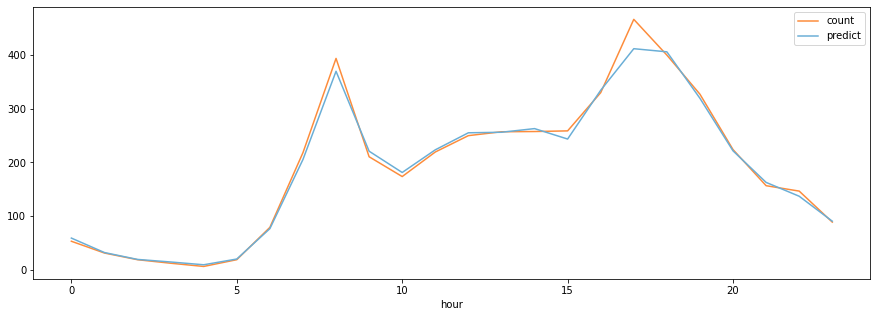

Fold:2
RMSLE: 0.32894081712550394
-13516.172736877004
14448.37506090268


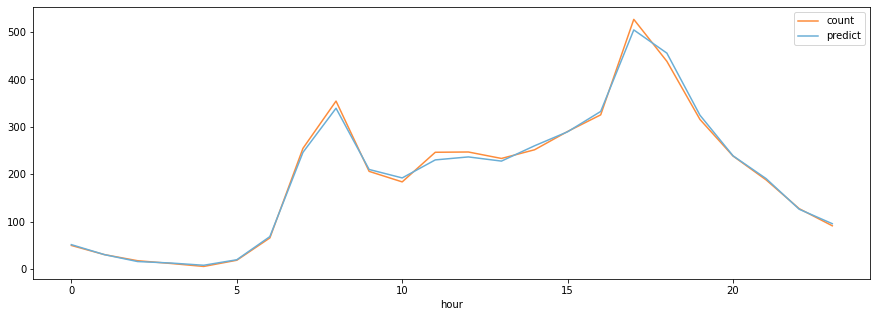

Fold:3
RMSLE: 0.3145966901268455
-11151.204254417875
14549.576743298087


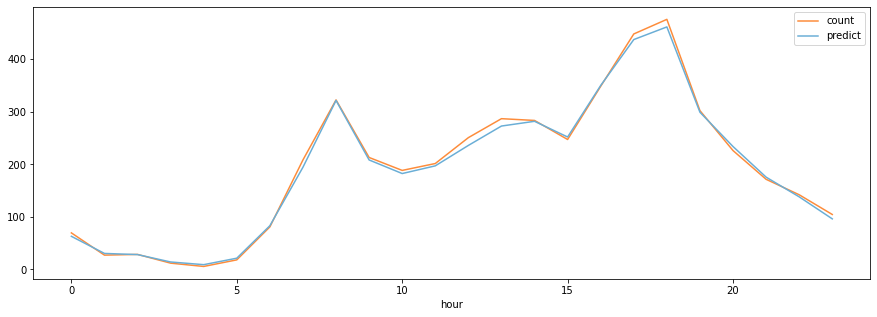

Fold:4
RMSLE: 0.3637935346985366
-12272.726707318037
16427.502251213384


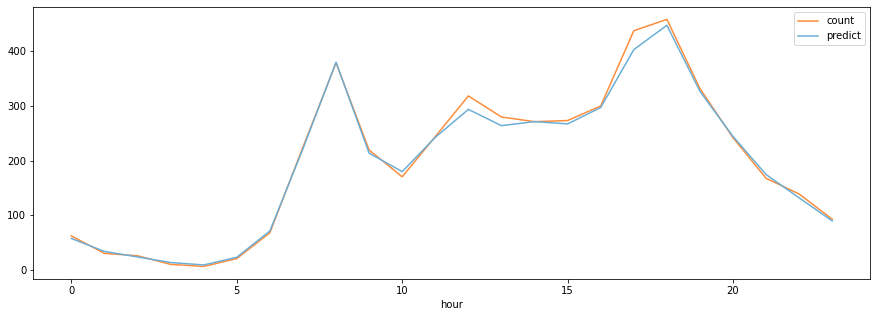

Fold:5
RMSLE: 0.33983253513510925
-12075.262966938335
14993.988484109663


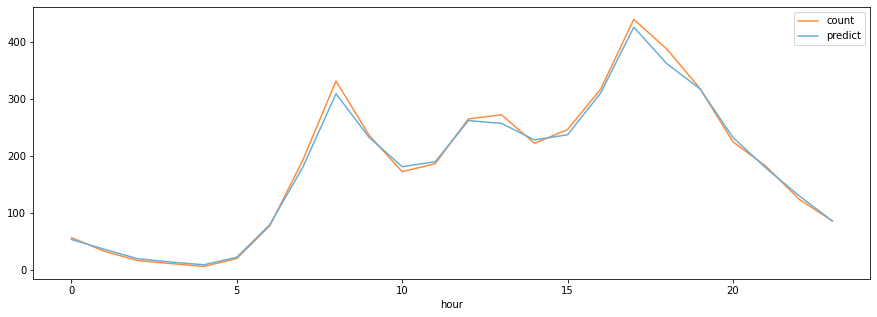

Fold:6
RMSLE: 0.31825914699263896
-13320.507655560163
14041.426185516284


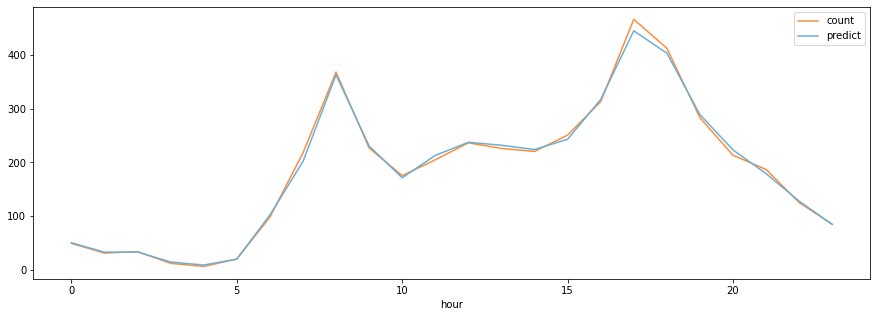

Fold:7
RMSLE: 0.31622680574910184
-12932.272028744643
14992.875526924703


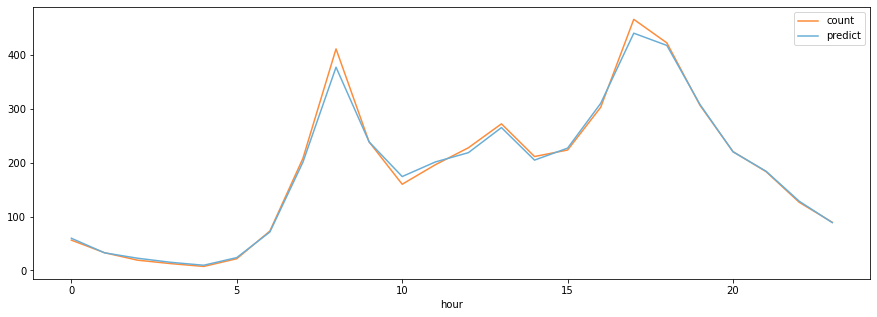

Fold:8
RMSLE: 0.3247354168676699
-12659.849619870687
15080.492289691338


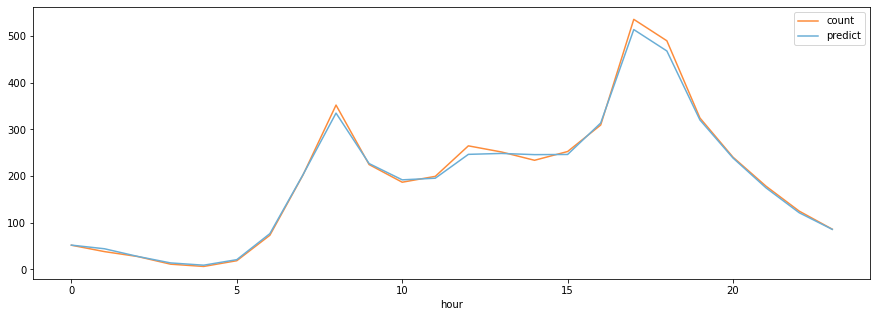

Fold:9
RMSLE: 0.33375943424835885
-13084.699052446344
14350.519987140719


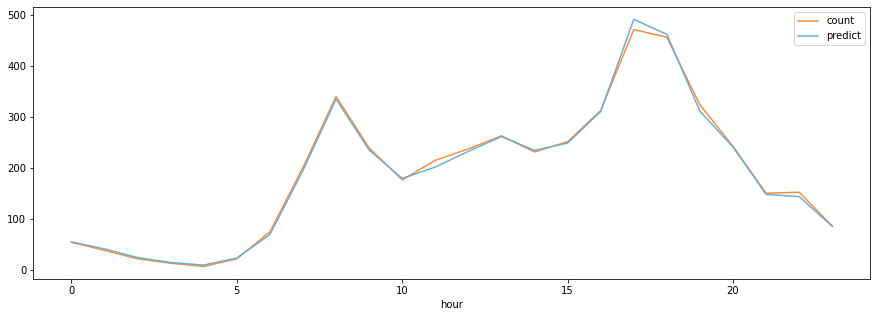

Fold:10
RMSLE: 0.3497498915089622
-11515.047912010134
13658.102610039825


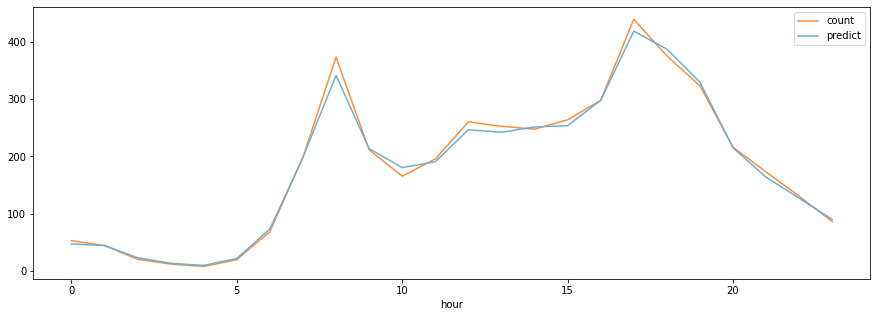

In [65]:
#count log
kf = KFold(n_splits=10, shuffle=True, random_state=1).split(train_0, train_y_log)
kf_ = list(kf)

cnt = 0
sum = 0
for Ktrain, Ktest in kf_:
    cnt += 1
    model = lgb.LGBMRegressor()
    model.fit(train_0.loc[Ktrain],
              train_y_log.loc[Ktrain],
              eval_set = [(train_0.loc[Ktest], train_y_log.loc[Ktest])],
              eval_metric = 'rmsle',                         
              verbose=0)
 
    y_pred_log = model.predict(train_0.loc[Ktest])
    y_pred = np.exp(y_pred_log) + 1
    #y_pred[y_pred < 0] = 0                                    
    
    print(f"Fold:{cnt}")
    print('RMSLE:', np.sqrt(mean_squared_log_error(train_y.loc[Ktest], y_pred)))
    diff = train_y.loc[Ktest] - y_pred
    print(diff[diff<0].sum())
    print(diff[diff>0].sum())
    
    true_df = train_df.loc[Ktest][['count', 'hour']].groupby(['hour'], as_index = True).mean().sort_values(by = 'count')
    
    trainhour = train_0.loc[Ktest]['hour'].reset_index()
    pred_df = pd.concat([trainhour['hour'], pd.Series(y_pred)], axis=1)
    pred_df.columns = ['hour','predict']
    pred_df = pred_df.groupby(['hour'], as_index = True).mean().sort_values(by = 'predict')
    
    fig = plt.figure(figsize=(15,5))
    sns.lineplot(data=true_df, palette='Oranges')
    sns.lineplot(data=pred_df, palette='Blues')
    plt.show()

In [66]:
#sklearnとxgboostをインポート
import xgboost as xgb
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [67]:
#訓練・テストデータに分割
X_train, X_test, y_train, y_test = train_test_split(train_0, train_y, test_size=0.2, shuffle=True)

In [68]:
len(y_train[y_train<=0])

0

# グリッドサーチ

In [69]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from lightgbm import LGBMRegressor
import time
from sklearn.metrics import mean_squared_error,r2_score
start = time.time()
y_train_log = np.log1p(y_train + 1)
# 乱数シード
seed = 42
 # KFoldでクロスバリデーション分割指定
cv = KFold(n_splits=3, shuffle=True, random_state=seed) 
# モデル作成
model = LGBMRegressor(boosting_type='gbdt', objective='regression',
                      random_state=seed, n_estimators=10000)  # チューニング前のモデル
# 学習時fitパラメータ指定
fit_params = {'verbose': 0,  # 学習中のコマンドライン出力
              'early_stopping_rounds': 10,  # 学習時、評価指標がこの回数連続で改善しなくなった時点でストップ
              'eval_metric': 'rmse',  # early_stopping_roundsの評価指標
              'eval_set': [(X_test, y_test)]  # early_stopping_roundsの評価指標算出用データ
              }


In [70]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error,r2_score

import time
start = time.time()
# 乱数シード
seed = 42
# モデル作成
model = LGBMRegressor(boosting_type='gbdt', objective='regression',
                      random_state=seed, n_estimators=2000)  # チューニング前のモデル
scoring = 'neg_mean_squared_error'  # 評価指標をRMSLEに指定
# 最終的なパラメータ範囲（1152通り）
cv_params = {'reg_alpha': [0.0001, 0.001, 0.01, 0.1],
             'reg_lambda': [0.0001, 0.001, 0.01, 0.1],
             'num_leaves': [4, 5, 6, 7, 8],
             'colsample_bytree': [ 0.5, 0.6, 0.7, 0.8, 0.9],
             'subsample': [0.4, 0.6, 0.8],
             'subsample_freq': [0, 2, 4],
             'min_child_samples': [5,7,8,9,10]
             }
# グリッドサーチのインスタンス作成
gridcv = GridSearchCV(model, cv_params,scoring=scoring, cv=5, n_jobs=-1)
# グリッドサーチ実行（学習実行）
gridcv.fit(X_train, y_train, **fit_params)
# 最適パラメータの表示と保持
best_params = gridcv.best_params_
best_score = gridcv.best_score_
print(f'最適パラメータ {best_params}\nスコア {best_score}')
print(f'所要時間{time.time() - start}秒')
print(f'所要時間{(time.time() - start)/60}分')


最適パラメータ {'colsample_bytree': 0.8, 'min_child_samples': 9, 'num_leaves': 8, 'reg_alpha': 0.001, 'reg_lambda': 0.001, 'subsample': 0.4, 'subsample_freq': 0}
スコア -1649.153088547521
所要時間4047.6567294597626秒
所要時間67.46094549099604分


In [71]:
#パラメータが最適化されたモデルを作成
opt_model = gridcv.best_estimator_
#予測
y_pred_train = opt_model.predict(X_train)
y_pred_test = opt_model.predict(X_test)

y_pred_train = y_pred_train.astype(int)
y_pred_train[y_pred_train<0] = 0
y_pred_test = y_pred_test.astype(int)
y_pred_test[y_pred_test<0] = 0

In [72]:
# 学習モデルの評価（RMSEを計算）
from sklearn.metrics import mean_squared_log_error
print('RMSE(train data):',round(np.sqrt(mean_squared_error(y_train, y_pred_train)),3))
print('RMSLE(train data):',round(np.sqrt(mean_squared_log_error(y_train, y_pred_train)),3))
print('RMSE(test data):',round(np.sqrt(mean_squared_error(y_test, y_pred_test)),3))
print('RMSLE(test data):',round(np.sqrt(mean_squared_log_error(y_test, y_pred_test)),3))
diff = y_test - y_pred_test
print(f'diff[diff<0].sum() = {diff[diff<0].sum()}')
print(f'diff[diff>0].sum() = {diff[diff>0].sum()}')

RMSE(train data): 35.528
RMSLE(train data): 0.481
RMSE(test data): 40.205
RMSLE(test data): 0.505
diff[diff<0].sum() = -29611
diff[diff>0].sum() = 26171


In [73]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error,r2_score

import time
start = time.time()
y_train_log = np.log1p(y_train +1)
# 乱数シード
seed = 42
# モデル作成
model = LGBMRegressor(boosting_type='gbdt', objective='regression',
                      random_state=seed, n_estimators=3000)  # チューニング前のモデル
scoring = 'neg_mean_squared_error'  # 評価指標をRMSLEに指定
# 最終的なパラメータ範囲
cv_params = {'reg_alpha': [0.0001, 0.001, 0.01, 0.1],
             'reg_lambda': [0.0001, 0.001, 0.01, 0.1],
             'num_leaves': [2, 3, 4, 5, 6],
             'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             'subsample': [0.4, 0.6, 0.8, 1.0],
             'subsample_freq': [0, 2, 4, 6],
             'min_child_samples': [0, 2, 5,7,8,9, 10]
             }
# グリッドサーチのインスタンス作成
gridcv = GridSearchCV(model, cv_params,scoring=scoring, cv=5, n_jobs=-1)
# グリッドサーチ実行（学習実行）
gridcv.fit(X_train, y_train_log, **fit_params)
# 最適パラメータの表示と保持
best_params = gridcv.best_params_
best_score = gridcv.best_score_
print(f'最適パラメータ {best_params}\nスコア {best_score}')
print(f'所要時間{time.time() - start}秒')
print(f'所要時間{(time.time() - start)/60}分')


最適パラメータ {'colsample_bytree': 1.0, 'min_child_samples': 8, 'num_leaves': 6, 'reg_alpha': 0.01, 'reg_lambda': 0.1, 'subsample': 0.4, 'subsample_freq': 0}
スコア -0.0760489546635095
所要時間6911.711614608765秒
所要時間115.19519357681274分


In [74]:
#パラメータが最適化されたモデルを作成
opt_model = gridcv.best_estimator_
#予測
y_pred_train_log = opt_model.predict(X_train)
y_pred_test_log = opt_model.predict(X_test)

y_pred_train = np.exp(y_pred_train_log) - 1
y_pred_test = np.exp(y_pred_test_log) - 1
y_pred_train = y_pred_train.astype(int)
y_pred_train[y_pred_train<0] = 0
y_pred_test = y_pred_test.astype(int)
y_pred_test[y_pred_test<0] = 0

In [75]:
# 学習モデルの評価（RMSEを計算）
from sklearn.metrics import mean_squared_log_error
print('RMSE(train data):',round(np.sqrt(mean_squared_error(y_train, y_pred_train)),3))
print('RMSLE(train data):',round(np.sqrt(mean_squared_log_error(y_train, y_pred_train)),3))
print('RMSE(test data):',round(np.sqrt(mean_squared_error(y_test, y_pred_test)),3))
print('RMSLE(test data):',round(np.sqrt(mean_squared_log_error(y_test, y_pred_test)),3))
diff = y_test - y_pred_test
print(f'diff[diff<0].sum() = {diff[diff<0].sum()}')
print(f'diff[diff>0].sum() = {diff[diff>0].sum()}')

RMSE(train data): 41.941
RMSLE(train data): 0.279
RMSE(test data): 42.365
RMSLE(test data): 0.287
diff[diff<0].sum() = -22769
diff[diff>0].sum() = 32408


In [76]:
test_df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,weekday,year,month
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,0,3,2011,1
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,3,2011,1
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2,3,2011,1
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,3,3,2011,1
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,4,3,2011,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,19,0,2012,12
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,20,0,2012,12
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,21,0,2012,12
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,22,0,2012,12


In [80]:
#提出用１
#model = lgb.LGBMRegressor()
y_pred_test = opt_model.predict(test_log)
y_pred_test[y_pred_test < 0] = 0  
sub0 = pd.concat([test_datetime, pd.Series(y_pred_test)], axis=1)
sub0.columns = ['datetime','count']
sub0.to_csv('bikeLGBM_log2.csv', index = False)

# Optunaベイズ最適化＆クロスバリデーションの実装

In [ ]:
import optuna
start = time.time()
# ベイズ最適化時の評価指標算出メソッド
def bayes_objective(trial):
    params = {
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0001, 0.1, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0001, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 6),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 0, 10)
    }
    # モデルにパラメータ適用
    model.set_params(**params)
    # cross_val_scoreでクロスバリデーション
    scores = cross_val_score(model, X, y, cv=cv,
                             scoring=scoring, fit_params=fit_params, n_jobs=-1)
    val = scores.mean()
    return val

# ベイズ最適化を実行
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(seed=seed))
study.optimize(bayes_objective, n_trials=400)

# 最適パラメータの表示と保持
best_params = study.best_trial.params
best_score = study.best_trial.value
print(f'最適パラメータ {best_params}\nスコア {best_score}')
print(f'所要時間{time.time() - start}秒')
print(f'所要時間{(time.time() - start)/60}分')

ModuleNotFoundError: No module named 'optuna'

# クロスバリデーションで可視化し，最適パラメータを手動補正する

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
# 乱数シード
seed = 42
# モデル作成
model = LGBMRegressor(boosting_type='gbdt', objective='regression',
                      random_state=seed, n_estimators=10000)  # チューニング前のモデル
# 学習時fitパラメータ指定
fit_params = {'verbose': 0,  # 学習中のコマンドライン出力
              'early_stopping_rounds': 10,  # 学習時、評価指標がこの回数連続で改善しなくなった時点でストップ
              'eval_metric': 'rmse',  # early_stopping_roundsの評価指標
              'eval_set': [(X_test, y_test)]  # early_stopping_roundsの評価指標算出用データ
              }
# クロスバリデーションして決定境界を可視化
cv = KFold(n_splits=3, shuffle=True, random_state=seed)  # KFoldでクロスバリデーション分割指定

In [ ]:
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
cv_params = {'reg_alpha': [0, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10],
             'reg_lambda': [0, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10],
             'num_leaves': [2, 4, 8, 16, 32, 64, 96, 128, 160, 192, 224, 256],
             'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             'subsample_freq': [0, 1, 2, 3, 4, 5, 6, 7],
             'min_child_samples': [0, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
             }
param_scales = {'reg_alpha': 'log',
                'reg_lambda': 'log',
                'num_leaves': 'linear',
                'colsample_bytree': 'linear',
                'subsample': 'linear',
                'subsample_freq': 'linear',
                'min_child_samples': 'linear'
                }
# 検証曲線のプロット（パラメータ毎にプロット）
for i, (k, v) in enumerate(cv_params.items()):
    train_scores, valid_scores = validation_curve(estimator=model,
                                                  X=X_train, y=y_train,
                                                  param_name=k,
                                                  param_range=v,
                                                  fit_params=fit_params,
                                                  cv=cv, scoring=scoring,
                                                  n_jobs=-1)
    # 学習データに対するスコアの平均±標準偏差を算出
    train_mean = np.mean(train_scores, axis=1)
    train_std  = np.std(train_scores, axis=1)
    train_center = train_mean
    train_high = train_mean + train_std
    train_low = train_mean - train_std
    # テストデータに対するスコアの平均±標準偏差を算出
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std  = np.std(valid_scores, axis=1)
    valid_center = valid_mean
    valid_high = valid_mean + valid_std
    valid_low = valid_mean - valid_std
    # training_scoresをプロット
    plt.plot(v, train_center, color='blue', marker='o', markersize=5, label='training score')
    plt.fill_between(v, train_high, train_low, alpha=0.15, color='blue')
    # validation_scoresをプロット
    plt.plot(v, valid_center, color='green', linestyle='--', marker='o', markersize=5, label='validation score')
    plt.fill_between(v, valid_high, valid_low, alpha=0.15, color='green')
    # スケールをparam_scalesに合わせて変更
    plt.xscale(param_scales[k])
    # 軸ラベルおよび凡例の指定
    plt.xlabel(k)  # パラメータ名を横軸ラベルに
    plt.ylabel(scoring)  # スコア名を縦軸ラベルに
    plt.legend(loc='lower right')  # 凡例
    # グラフを描画
    plt.show()

NameError: name 'scoring' is not defined